## Old

In [8]:
import os
import time
from contextlib import nullcontext

import numpy as np
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # must be BEFORE torch/TF import
from torch.nn.parallel import DistributedDataParallel as DDP

from model import GPTConfig, GPT
from utils.train_utils import build_dataloader, build_tokenizer

torch.cuda.set_device(0)   # 0 here means "the first visible GPU", i.e. physical #3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
from utils.train_utils import build_dataloader, build_tokenizer

In [10]:
## Training Args
batch_size = 128
seq_len = 96
block_size = seq_len
learning_rate = 5e-4
weight_decay = 1e-1
epochs = 500  # Increased for early stopping
grad_accumulation_steps = 1
clip_grad = 1.0
seed = 42
warmup_steps = 0
min_lr_factor = 0.1
decay_lr = True
compile = True
output_dir = "output"
save_every = 10
# eval_every = 100  # Evaluate every 5 epochs
patience = 10   # Early stopping patience
compile = False
dataset_name = 'ETTm1'
features = 'M'

In [11]:
# model
vocab_size = 512
quant_range = 4
n_layer = 2
n_head = 4
n_embd = 16
dropout = 0.1 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?

In [12]:
# adamw optimizer
beta1 = 0.9
beta2 = 0.95

In [13]:
# learning rate decay settings
decay_lr = True # whether to decay the learning rate

In [14]:
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
device_type = 'cuda' if torch.cuda.is_available() else 'cpu' # 'cuda', 'cpu', or 'mps' for macbooks
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = False # use PyTorch 2.0 to compile the model to be faster

In [15]:
# Create output directory
from pathlib import Path
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [16]:
from utils.train_utils import build_dataloader, build_tokenizer

train_dataset, train_loader = build_dataloader(
    dataset_name=dataset_name,
    features=features, 
    seq_len=seq_len, 
    label_len=seq_len - 1, 
    pred_len=1, 
    flag='train', 
    batch_size=batch_size,
    pretrain=False
    )

validate_dataset, validate_loader = build_dataloader(
    dataset_name=dataset_name,
    features=features, 
    seq_len=seq_len, 
    label_len=seq_len - 1, 
    pred_len=1, 
    flag='val', 
    batch_size=batch_size,
    pretrain=False
    )

print(f"Dataset: {dataset_name}, Features: {features}, Batch Size: {batch_size}, Seq Len: {seq_len}")

[INFO] train set: 241248 samples, 1884 batches
[INFO] val set: 80640 samples, 630 batches
Dataset: ETTm1, Features: M, Batch Size: 128, Seq Len: 96


In [17]:
# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

In [18]:
# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=vocab_size, dropout=dropout)
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
model.to(device)


torch.set_float32_matmul_precision('high')
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))
print(f"Using precision: {dtype}")

number of parameters: 0.01M
Using precision: bfloat16


In [19]:
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
model = torch.compile(model)


num decayed parameter tensors: 10, with 15,872 parameters
num non-decayed parameter tensors: 5, with 80 parameters
using fused AdamW: True


In [20]:
@torch.no_grad()
def evaluate(model, val_loader, tokenizer, device):
    model.eval()
    total_val_loss = 0
    num_batches = len(val_loader)
    
    for batch_x, batch_y, _, _ in val_loader:
        x = batch_x.float().squeeze(-1).to(device)
        y = batch_y.float().squeeze(-1).to(device)
        
        # Tokenize inputs
        token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.cpu())
        target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.cpu(), tokenizer_state)
        
        # Move to device
        token_ids = token_ids.to(device)
        target_token_ids = target_token_ids.to(device)
        
        # Forward pass (no grad)
        logits, loss = model(token_ids, target_token_ids)
        total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / num_batches
    return avg_val_loss


In [21]:
"""
Training function with early stopping, periodic evaluation, and WandB logging
"""
from tqdm import tqdm
from utils.train_utils import get_lr


# Initialize components
tokenizer = build_tokenizer(
    quant_range=quant_range,
    vocab_size=vocab_size,
    context_length=seq_len,
    prediction_length=seq_len
)

In [22]:
"""
Training function with early stopping, periodic evaluation, and WandB logging
"""
from tqdm import tqdm
from utils.train_utils import get_lr


# Initialize components
tokenizer = build_tokenizer(
    quant_range=quant_range,
    vocab_size=vocab_size,
    context_length=seq_len,
    prediction_length=seq_len
)


num_batches = len(train_loader)
total_steps = epochs * num_batches
min_lr = learning_rate * min_lr_factor
best_val_loss = float('inf')


# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    t1 = time.time()
    epoch_loss = 0
    current_lr = 0
    batch_losses = []
    
    progress_bar = tqdm(
        enumerate(train_loader), 
        total=len(train_loader), 
        desc=f"🏃 Epoch {epoch+1}/{epochs}", 
        position=0, 
        leave=True
    )
    
    for i, (batch_x, batch_y, _, _) in progress_bar:
        iteration = epoch * num_batches + i
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Get learning rate
        lr = get_lr(iteration, total_steps, warmup_steps, learning_rate, min_lr, decay_lr)
        current_lr = lr
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        # Gradient accumulation loop
        for micro_step in range(grad_accumulation_steps):
            token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            target_token_ids, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
            
            # Forward pass
            logits, loss = model(token_ids.to(device), target_token_ids.to(device))
            
            # Calculate loss
            loss = loss / grad_accumulation_steps
            
            # Backward pass
            scaler.scale(loss).backward()
            total_loss += loss.item() * grad_accumulation_steps
        
        # Gradient clipping
        if clip_grad > 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
        else:
            grad_norm = 0
            
        # Update weights
        scaler.step(optimizer)
        scaler.update()
        
        # Update metrics
        epoch_loss += total_loss
        batch_losses.append(total_loss)
        avg_epoch_loss = epoch_loss / (i + 1)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{total_loss:.4f}",
            'avg_loss': f"{avg_epoch_loss:.4f}",
            'lr': f"{lr:.6f}"
        })
    
    # --- End of batch loop ---

    # Calculate train loss for epoch
    train_time = time.time() - t1
    train_avg_loss = epoch_loss / len(train_loader)

    # --- Validation phase ---
    t2 = time.time()
    val_avg_loss = evaluate(model, validate_loader, tokenizer, device)
    val_time = time.time() - t2

    print(f"✅ Epoch {epoch+1} | Train Loss: {train_avg_loss:.4f} | Val Loss: {val_avg_loss:.4f} | Time: {train_time:.2f}s (Train) / {val_time:.2f}s (Val)")

    # Save best model
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        torch.save(model.state_dict(), f'best_model_epoch_{epoch+1}.pt')
        print("💾 Best model saved!")
    

# Training completed
print(f"\n🎉 Training completed!")



🏃 Epoch 1/500:   0%|          | 0/1884 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
"""
Training function with early stopping, periodic evaluation, and WandB logging
"""
from tqdm import tqdm
from utils.train_utils import get_lr
import time
import torch


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=12, verbose=False, delta=0, save_path='best_model.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement. 
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            save_path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.save_path = save_path

    def __call__(self, val_loss, model, epoch):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'⏳ EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'💾 Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
        }, self.save_path)
        self.val_loss_min = val_loss


# Initialize components
tokenizer = build_tokenizer(
    quant_range=quant_range,
    vocab_size=vocab_size,
    context_length=seq_len,
    prediction_length=seq_len
)

num_batches = len(train_loader)
total_steps = epochs * num_batches
min_lr = learning_rate * min_lr_factor
best_val_loss = float('inf')

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=12, 
    verbose=True, 
    save_path=f'best_model_checkpoint.pt'
)

# Training statistics tracking
training_stats = {
    'train_losses': [],
    'val_losses': [],
    'learning_rates': [],
    'epochs_completed': 0,
    'best_epoch': 0,
    'total_training_time': 0
}

print(f"🚀 Starting training for {epochs} epochs with early stopping (patience={early_stopping.patience})")
print(f"📊 Total steps: {total_steps}, Batches per epoch: {num_batches}")

# Training loop
training_start_time = time.time()

for epoch in range(epochs):
    # Training phase
    model.train()
    t1 = time.time()
    epoch_loss = 0
    current_lr = 0
    batch_losses = []
    
    progress_bar = tqdm(
        enumerate(train_loader), 
        total=len(train_loader), 
        desc=f"🏃 Epoch {epoch+1}/{epochs}", 
        position=0, 
        leave=True
    )
    
    for i, (batch_x, batch_y, _, _) in progress_bar:
        iteration = epoch * num_batches + i
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Get learning rate
        lr = get_lr(iteration, total_steps, warmup_steps, learning_rate, min_lr, decay_lr)
        current_lr = lr
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        # Gradient accumulation loop
        for micro_step in range(grad_accumulation_steps):
            token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            target_token_ids, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
            
            # Forward pass
            logits, loss = model(token_ids.to(device), target_token_ids.to(device))
            
            # Calculate loss
            loss = loss / grad_accumulation_steps
            
            # Backward pass
            scaler.scale(loss).backward()
            total_loss += loss.item() * grad_accumulation_steps
        
        # Gradient clipping
        if clip_grad > 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        else:
            grad_norm = 0
            
        # Update weights
        scaler.step(optimizer)
        scaler.update()
        
        # Update metrics
        epoch_loss += total_loss
        batch_losses.append(total_loss)
        avg_epoch_loss = epoch_loss / (i + 1)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{total_loss:.4f}",
            'avg_loss': f"{avg_epoch_loss:.4f}",
            'lr': f"{lr:.6f}",
            'patience': f"{early_stopping.counter}/{early_stopping.patience}"
        })
    
    # --- End of batch loop ---

    # Calculate train loss for epoch
    train_time = time.time() - t1
    train_avg_loss = epoch_loss / len(train_loader)

    # --- Validation phase ---
    t2 = time.time()
    val_avg_loss = evaluate(model, validate_loader, tokenizer, device)
    val_time = time.time() - t2

    # Update training statistics
    training_stats['train_losses'].append(train_avg_loss)
    training_stats['val_losses'].append(val_avg_loss)
    training_stats['learning_rates'].append(current_lr)
    training_stats['epochs_completed'] = epoch + 1

    # Check if this is the best validation loss
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        training_stats['best_epoch'] = epoch + 1

    print(f"✅ Epoch {epoch+1}/{epochs} | Train Loss: {train_avg_loss:.4f} | Val Loss: {val_avg_loss:.4f} | "
          f"Best Val: {best_val_loss:.4f} | Time: {train_time:.2f}s (Train) / {val_time:.2f}s (Val) | "
          f"LR: {current_lr:.6f}")

    # Early stopping check
    early_stopping(val_avg_loss, model, epoch + 1)
    
    if early_stopping.early_stop:
        print(f"\n🛑 Early stopping triggered after {epoch + 1} epochs!")
        print(f"📈 Best validation loss: {early_stopping.val_loss_min:.6f}")
        print(f"⏱️  No improvement for {early_stopping.patience} consecutive epochs")
        break
    
    # # Optional: Log to WandB if available
    # try:
    #     import wandb
    #     wandb.log({
    #         'epoch': epoch + 1,
    #         'train_loss': train_avg_loss,
    #         'val_loss': val_avg_loss,
    #         'learning_rate': current_lr,
    #         'best_val_loss': best_val_loss,
    #         'early_stopping_counter': early_stopping.counter,
    #         'train_time': train_time,
    #         'val_time': val_time
    #     })
    # except ImportError:
    #     pass  # WandB not available

# Calculate total training time
total_training_time = time.time() - training_start_time
training_stats['total_training_time'] = total_training_time

# Training completed
print(f"\n🎉 Training completed!")
print(f"📊 Training Summary:")
print(f"   • Total epochs: {training_stats['epochs_completed']}")
print(f"   • Best epoch: {training_stats['best_epoch']}")
print(f"   • Best validation loss: {best_val_loss:.6f}")
print(f"   • Total training time: {total_training_time:.2f}s ({total_training_time/60:.2f}m)")
print(f"   • Average time per epoch: {total_training_time/training_stats['epochs_completed']:.2f}s")

# Load best model for final evaluation
if early_stopping.save_path:
    print(f"🔄 Loading best model from {early_stopping.save_path}")
    checkpoint = torch.load(early_stopping.save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Best model loaded (epoch {checkpoint['epoch']}, val_loss: {checkpoint['val_loss']:.6f})")

# Optional: Save training statistics
torch.save(training_stats, 'training_statistics.pt')
print(f"📁 Training statistics saved to training_statistics.pt")

In [ ]:
logits, loss = model(token_ids.to(device), target_token_ids.to(device))

In [ ]:
logits.shape

In [ ]:
import torch
import torch.nn.functional as F

def compute_entropy_all_tokens(logits: torch.Tensor) -> torch.Tensor:
    """
    logits: [B, T, V] — raw output logits
    Returns:
        entropy: [B, 1, T] — entropy for each output token's distribution
    """
    probs = F.softmax(logits, dim=-1)  # [B, T, V]
    entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)  # [B, T]
    entropy = entropy.unsqueeze(1)  # [B, 1, T]
    return entropy
logits, _ = model(token_ids.to(device))              # logits: [256, 96, vocab_size]
entropy = compute_entropy_all_tokens(logits)  # entropy: [256, 1, 96]


In [ ]:
entropy[0]

In [ ]:
# Initialize components
tokenizer = build_tokenizer(
    quant_range=3,
    vocab_size=512,
    context_length=96,
    prediction_length=96
)

In [ ]:
"""
Training function with early stopping, periodic evaluation, and WandB logging
"""
from tqdm import tqdm
from utils.train_utils import EarlyStopping, get_lr, validate


# Initialize components
tokenizer = build_tokenizer(
    quant_range=quant_range,
    vocab_size=vocab_size,
    context_length=seq_len,
    prediction_length=seq_len
)

early_stopping = EarlyStopping(patience=patience, min_delta=1e-6)
# logger = TrainingLogger(output_dir, dataset_name, enable_wandb=ENABLE_WANDB)

num_batches = len(train_loader)
total_steps = epochs * num_batches
min_lr = learning_rate * min_lr_factor
best_val_loss = float('inf')

print(f"\n🚀 Starting training with early stopping...")
print(f"📝 Configuration:")
print(f"   Max epochs: {epochs}")
print(f"   Early stopping patience: {patience}")
print(f"   Save every: {save_every} epochs")
# print(f"   WandB logging: {'Enabled' if ENABLE_WANDB else 'Disabled'}")

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    t1 = time.time()
    epoch_loss = 0
    current_lr = 0
    batch_losses = []
    
    progress_bar = tqdm(
        enumerate(train_loader), 
        total=len(train_loader), 
        desc=f"🏃 Epoch {epoch+1}/{epochs}", 
        position=0, 
        leave=True
    )
    
    for i, (batch_x, batch_y, _, _) in progress_bar:
        iteration = epoch * num_batches + i
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Get learning rate
        lr = get_lr(iteration, total_steps, warmup_steps, learning_rate, min_lr, decay_lr)
        current_lr = lr
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        # Gradient accumulation loop
        for micro_step in range(grad_accumulation_steps):
            token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            target_token_ids, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
            
            # Forward pass
            logits, loss = model(token_ids.to(device), target_token_ids.to(device))
            
            # Calculate loss
            loss = loss / grad_accumulation_steps
            
            # Backward pass
            scaler.scale(loss).backward()
            total_loss += loss.item() * grad_accumulation_steps
        
        # Gradient clipping
        if clip_grad > 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
        else:
            grad_norm = 0
            
        # Update weights
        scaler.step(optimizer)
        scaler.update()
        
        # Update metrics
        epoch_loss += total_loss
        batch_losses.append(total_loss)
        avg_epoch_loss = epoch_loss / (i + 1)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{total_loss:.4f}",
            'avg_loss': f"{avg_epoch_loss:.4f}",
            'lr': f"{lr:.6f}",
            'patience': f"{early_stopping.counter}/{patience}"
        })
    
    # Calculate training metrics
    train_time = time.time() - t1
    train_avg_loss = epoch_loss / len(train_loader)
    train_std_loss = np.std(batch_losses) if len(batch_losses) > 1 else 0
    
    # Validation phase
    print(f"\n🔍 Running validation for epoch {epoch+1}...")
    t1 = time.time()
    model.eval()
    val_loss = validate(model, validate_loader, tokenizer, device, 
                        desc=f"Epoch {epoch+1} Validation")
    val_time = time.time() - t1
    
    # Print epoch results
    print(f"\n📊 Epoch {epoch+1}/{epochs} Results:")
    print(f"   Training Loss: {train_avg_loss:.6f} ± {train_std_loss:.6f} (Time: {train_time:.2f}s)")
    print(f"   Validation Loss: {val_loss:.6f} (Time: {val_time:.2f}s)")
    print(f"   Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss,
            'train_loss': train_avg_loss,
            'model_args': model.config.__dict__
        }
        torch.save(checkpoint, os.path.join(output_dir, f'best_entropy_model_{dataset_name}_{features}_{seq_len}.pth'))
        print(f"   ✅ New best model saved! (Val Loss: {best_val_loss:.6f})")
        
    
    # Save periodic checkpoint
    if save_every > 0 and (epoch + 1) % save_every == 0:
        checkpoint_path = os.path.join(output_dir, f'checkpoint_{seq_len}_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss,
            'train_loss': train_avg_loss,
            'model_args': model.config.__dict__
        }, checkpoint_path)
        print(f"   💾 Checkpoint saved at epoch {epoch+1}")
    
    # Early stopping check
    if early_stopping(val_loss, model):
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
        print(f"   No improvement for {patience} consecutive epochs")
        print(f"   Best validation loss: {early_stopping.best_loss:.6f}")
        break

# Training completed
print(f"\n🎉 Training completed!")

# Print summary
# logger.print_summary()

# Save final model
final_checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler.state_dict() if scaler else None,
    'val_loss': val_loss,
    'train_loss': train_avg_loss,
    'early_stopped': early_stopping.counter >= patience,
    'model_args': model.config.__dict__,
    'final_metrics': {
        'best_val_loss': best_val_loss,
        'total_epochs': epoch + 1,
        'total_training_time': time.time()
    }
}
torch.save(final_checkpoint, os.path.join(output_dir, f'final_entropy_model_{dataset_name}_{features}_{seq_len}.pth'))


In [ ]:
logits.shape

In [ ]:
# Load and evaluate best model
print("\nEvaluating best model on test set...")
checkpoint = torch.load(os.path.join(output_dir, f"best_entropy_model_{dataset_name}_{features}_{seq_len}.pth"))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Saved Val loss: {checkpoint['val_loss'].item()}")

In [ ]:
# Periodic evaluation

from utils.eval_utils import evaluation

eval_results = None

print(f"\n🎯 Running full evaluation at ...")
try:
    eval_results = evaluation(
        model, 
        dataset_name, 
        features,
        quant_range,
        vocab_size,
        input_len=96,
        pred_len=96,
        eval_batch_size=batch_size,
        device=device
    )
    print(f"   📈 Evaluation completed successfully!")
except Exception as e:
    print(f"   ❌ Evaluation failed: {e}")
    eval_results = None

In [ ]:
"""
Entropy calculation functions for transformer logits
"""

import torch
import torch.nn.functional as F
import numpy as np


def calculate_entropy(logits, dim=-1, temperature=1.0, eps=1e-8):
    """
    Calculate entropy of probability distributions from logits.
    
    Args:
        logits (torch.Tensor): Raw logits of shape (..., vocab_size)
        dim (int): Dimension along which to calculate entropy (default: -1, last dimension)
        temperature (float): Temperature for softmax scaling (default: 1.0)
        eps (float): Small epsilon to avoid log(0) (default: 1e-8)
    
    Returns:
        torch.Tensor: Entropy values with shape (..., 1) where last dim is squeezed
    """
    # Scale logits by temperature
    scaled_logits = logits / temperature
    
    # Convert logits to probabilities using softmax
    probs = F.softmax(scaled_logits, dim=dim)
    
    # Add small epsilon to avoid log(0)
    probs = probs + eps
    
    # Calculate entropy: H(P) = -sum(p * log(p))
    log_probs = torch.log(probs)
    entropy = -torch.sum(probs * log_probs, dim=dim, keepdim=True)
    
    return entropy


def calculate_entropy_batch(logits, temperature=1.0, eps=1e-8):
    """
    Calculate entropy for batch of sequences.
    Specifically designed for transformer outputs.
    
    Args:
        logits (torch.Tensor): Logits of shape (batch_size, seq_len, vocab_size)
        temperature (float): Temperature for softmax scaling
        eps (float): Small epsilon to avoid numerical issues
    
    Returns:
        torch.Tensor: Entropy tensor of shape (batch_size, seq_len, 1)
    """
    batch_size, seq_len, vocab_size = logits.shape
    
    # Calculate entropy for each position in each sequence
    entropy = calculate_entropy(logits, dim=-1, temperature=temperature, eps=eps)
    
    return entropy


def calculate_entropy_stats(logits, temperature=1.0, eps=1e-8):
    """
    Calculate entropy along with useful statistics.
    
    Args:
        logits (torch.Tensor): Logits of shape (batch_size, seq_len, vocab_size)
        temperature (float): Temperature for softmax scaling
        eps (float): Small epsilon to avoid numerical issues
    
    Returns:
        dict: Dictionary containing entropy and statistics
    """
    # Calculate entropy
    entropy = calculate_entropy_batch(logits, temperature, eps)
    
    # Calculate maximum possible entropy (uniform distribution)
    vocab_size = logits.shape[-1]
    max_entropy = np.log(vocab_size)
    
    # Calculate statistics
    stats = {
        'entropy': entropy,  # Shape: (batch_size, seq_len, 1)
        'mean_entropy': entropy.mean(),
        'std_entropy': entropy.std(),
        'min_entropy': entropy.min(),
        'max_entropy_observed': entropy.max(),
        'max_entropy_theoretical': max_entropy,
        'normalized_entropy': entropy / max_entropy,  # Normalized to [0, 1]
        'entropy_per_sequence': entropy.mean(dim=1),  # Shape: (batch_size, 1)
        'entropy_per_position': entropy.mean(dim=0),  # Shape: (seq_len, 1)
    }
    
    return stats


def analyze_model_uncertainty(model, data_loader, tokenizer, device, num_batches=10):
    """
    Analyze model uncertainty by calculating entropy over multiple batches.
    
    Args:
        model: Trained model
        data_loader: Data loader for evaluation
        tokenizer: Tokenizer instance
        device: Device to run on
        num_batches: Number of batches to analyze
    
    Returns:
        dict: Analysis results with entropy statistics
    """
    model.eval()
    all_entropies = []
    
    with torch.no_grad():
        for i, (batch_x, batch_y, _, _) in enumerate(data_loader):
            if i >= num_batches:
                break
                
            x = batch_x.float().squeeze(-1)
            
            # Tokenize inputs
            token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            
            # Forward pass to get logits
            logits, _ = model(token_ids.to(device), target_token_ids=None)
            
            # Calculate entropy
            entropy = calculate_entropy_batch(logits)
            all_entropies.append(entropy)
    
    # Concatenate all entropies
    all_entropies = torch.cat(all_entropies, dim=0)  # Shape: (total_samples, seq_len, 1)
    
    # Calculate comprehensive statistics
    vocab_size = logits.shape[-1]
    max_entropy_theoretical = np.log(vocab_size)
    
    results = {
        'entropy_tensor': all_entropies,
        'mean_entropy': all_entropies.mean().item(),
        'std_entropy': all_entropies.std().item(),
        'min_entropy': all_entropies.min().item(),
        'max_entropy': all_entropies.max().item(),
        'max_entropy_theoretical': max_entropy_theoretical,
        'mean_normalized_entropy': (all_entropies.mean() / max_entropy_theoretical).item(),
        'entropy_by_position': all_entropies.mean(dim=0).squeeze(),  # Average entropy per position
        'samples_analyzed': all_entropies.shape[0],
        'sequence_length': all_entropies.shape[1],
        'vocab_size': vocab_size
    }
    
    return results


# Example usage function
def example_usage():
    """Example of how to use the entropy calculation functions"""
    
    # Simulate transformer output logits
    batch_size, seq_len, vocab_size = 256, 96, 512
    logits = torch.randn(batch_size, seq_len, vocab_size)
    
    print(f"Input logits shape: {logits.shape}")
    
    # Method 1: Simple entropy calculation
    entropy = calculate_entropy_batch(logits)
    print(f"Entropy shape: {entropy.shape}")  # Should be (256, 96, 1)
    print(f"Mean entropy: {entropy.mean().item():.4f}")
    
    # Method 2: Entropy with statistics
    stats = calculate_entropy_stats(logits)
    print(f"Entropy statistics:")
    print(f"  Mean: {stats['mean_entropy']:.4f}")
    print(f"  Std: {stats['std_entropy']:.4f}")
    print(f"  Min: {stats['min_entropy']:.4f}")
    print(f"  Max: {stats['max_entropy_observed']:.4f}")
    print(f"  Theoretical Max: {stats['max_entropy_theoretical']:.4f}")
    print(f"  Normalized Mean: {stats['normalized_entropy'].mean():.4f}")
    
    # Method 3: Different temperatures
    print(f"\nEntropy at different temperatures:")
    for temp in [0.1, 0.5, 1.0, 2.0, 5.0]:
        entropy_temp = calculate_entropy_batch(logits, temperature=temp)
        print(f"  Temperature {temp}: {entropy_temp.mean().item():.4f}")


# if __name__ == "__main__":
#     example_usage()

In [ ]:
calculate_entropy(logits).shape, logits.shape

In [ ]:
calculate_entropy(logits)[9].view(-1)

In [ ]:
import matplotlib.pyplot as plt

batch_position = 10  # Example batch position
y = calculate_entropy(logits)[batch_position].view(-1).detach().cpu().numpy()
x = x[batch_position]


plt.figure(figsize=(12, 4))
plt.plot(range(1, 97), y, marker='o')
plt.title("Entropy per Token (Sample 10 in Batch)")
plt.xlabel("Token Position (t)")
plt.ylabel("Entropy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

batch_position = 10

# Entropy: shape (96,)
y = calculate_entropy(logits)[batch_position].view(-1).detach().cpu().numpy()

# x already contains 96 values
x_values = x[10].view(-1).detach().cpu().numpy()

# Plot both
plt.figure(figsize=(12, 4))
plt.plot(range(1, 97), y, label="Entropy", color='blue', marker='o')
plt.plot(range(1, 97), x_values, label="X Variable", color='orange', marker='x')
plt.title("Entropy & X Variable per Token (Sample 10 in Batch)")
plt.xlabel("Token Position (t)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 2. Load the weights
checkpoint = torch.load("output/best_model_checkpoint.pt", map_location='cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])

# 3. Set to eval mode
model.eval()

## Load Model

In [1]:
from model import GPT, GPTConfig
from train_entropy_model import TrainingConfig as configs
import torch

# Define config
gptconf = GPTConfig(
    n_layer=configs.n_layer,
    n_head=configs.n_head,
    n_embd=configs.n_embd,
    dropout=configs.dropout,
    bias=configs.bias,
    vocab_size=configs.vocab_size,
    block_size=configs.block_size,
)

# Initialize and load model
model = GPT(gptconf)
checkpoint = torch.load("output/best_model_checkpoint.pt", map_location='cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()
print(f"✅ Best model loaded (epoch {checkpoint['epoch']}, val_loss: {checkpoint['val_loss']:.6f})")

number of parameters: 0.43M
✅ Best model loaded (epoch 8, val_loss: 3.192115)


In [2]:
gptconf

GPTConfig(block_size=96, vocab_size=256, n_layer=2, n_head=4, n_embd=128, dropout=0.2, bias=False)

In [3]:
"""
Training function with early stopping, periodic evaluation, and WandB logging
"""
from utils.train_utils import build_tokenizer

# Initialize components
tokenizer = build_tokenizer(
    quant_range=configs.quant_range,
    vocab_size=configs.vocab_size,
    context_length=configs.block_size,
    prediction_length=configs.block_size
)

In [4]:
from utils.train_utils import build_dataloader

validate_dataset, validate_loader = build_dataloader(
    dataset_name="ETTm1",
    features='M', 
    seq_len=configs.block_size, 
    label_len=configs.block_size - 1, 
    pred_len=1, 
    flag='test', 
    batch_size=configs.batch_size,
    pretrain=False
    )

import time
idx = torch.randint(0, 50, (1,)).item()
i = 0
for batch_x, batch_y, _, _ in validate_loader:
    t1 = time.time()
    x = batch_x.float().squeeze(-1).to('cuda')
    y = batch_y.float().squeeze(-1).to('cuda')
    
    # Tokenize inputs
    token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.cpu())
    
    # Move to device
    token_ids = token_ids.to('cuda')
    
    # Forward pass (no grad)
    logits, _ = model(token_ids)
    t2 = time.time()
    if idx == i:
        break  # Process only the first batch for timing
    i += 1

[INFO] test set: 80640 samples, 630 batches


In [5]:
logits.shape 

torch.Size([128, 96, 256])

In [6]:
tokens = token_ids
entropy_model = model
patching_batch_size = configs.batch_size
device = "cuda"
enable_grad = False

In [7]:
import torch.nn.functional as F


def entropy(scores):
    """
    scores: [bs, seq_len, vocab]
    returns [bs, seq_len]

    Computes the entropy for each token in the batch.
    Note: uses natural log.
    """
    log_probs = F.log_softmax(scores, dim=-1)
    probs = torch.exp(log_probs)
    p_log_p = log_probs * probs
    entropy = -p_log_p.sum(dim=-1)
    return entropy

def calculate_entropies(
    tokens: torch.tensor,
    entropy_model,
    patching_batch_size,
    device: str | None = None,
    enable_grad: bool = False,
):
    """
    tokens: 2D tensor of shape [batch_size, seq_len]
    Return 2D tensor of shape [batch_size, seq_len] with entropies for each token.

    Splits the tokens into chunks of size max_length and calculates entropies for each chunk.
    Entropy model can be executed on cpu or gpu, specify either 'cuda' or 'cpu' in the device argument.
    """

    grad_context = nullcontext() if enable_grad else torch.no_grad()

    with grad_context:
        entropies = []
        preds = []
        max_length = getattr(entropy_model, "max_length", 96)
        batch_numel = max_length * patching_batch_size
        splits = torch.split(tokens.flatten(), batch_numel)
        for split in splits:
            pad_size = (max_length - (split.numel() % max_length)) % max_length
            pad = torch.zeros(
                pad_size, dtype=split.dtype, device=split.device, requires_grad=False
            )
            split = torch.cat((split, pad), dim=0)
            split = split.reshape(-1, max_length)
            if device is not None:
                split = split.to(device)
            # assert torch.all(split >= 0) and torch.all(split < 260)
            pred, _ = entropy_model(split)

            pred = pred.reshape(-1, pred.shape[-1])[
                : split.numel() - pad_size, :
            ]  # [batch_size * seq_len, vocab]
            
            pred_entropies = entropy(pred)
            entropies.append(pred_entropies)

            preds.append(pred)

        concat_entropies = torch.cat(entropies, dim=0)
        concat_entropies = concat_entropies.reshape(tokens.shape)
        concat_preds = torch.cat(preds, dim=0)
        concat_preds = concat_preds.reshape(tokens.shape[0], -1)
    return concat_entropies, concat_preds

In [8]:
entropy_model.config

GPTConfig(block_size=96, vocab_size=256, n_layer=2, n_head=4, n_embd=128, dropout=0.2, bias=False)

In [9]:
entropies = calculate_entropies(tokens, entropy_model, patching_batch_size, device=device, enable_grad=False)
entropies[0].shape

torch.Size([128, 96])

## Entropy Exp

### Functions

In [10]:
def patch_start_mask_global_and_monotonicity(entropies, t, t_add=0):
    """
    entropies: [bs, seq_len] torch tensor of entropies
    t: threshold
    returns [bs, seq_len] mask where True indicates the start of a patch
    """
    bs, seq_len = entropies.shape

    if seq_len == 0:
        return entropies > t

    mask = torch.zeros_like(entropies, dtype=torch.bool)
    mask[:, 0] = True

    # Calculate differences between consecutive elements along the sequence length
    differences = entropies[:, 1:] - entropies[:, :-1]

    # Calculate conditions for all elements except the first one in each sequence
    condition = (differences > t_add) & (entropies[:, 1:] > t) & (~mask[:, :-1])

    # Update the mask based on the condition
    mask[:, 1:] = condition

    return mask

In [11]:
def patch_start_mask_from_entropy_with_monotonicity(entropies, t):
    """
    entropies: [bs, seq_len] torch tensor of entropies
    t: threshold
    returns [bs, seq_len] mask where True indicates the start of a patch
    """
    bs, seq_len = entropies.shape

    if seq_len == 0:
        return entropies > t

    mask = torch.zeros_like(entropies, dtype=torch.bool)
    mask[:, 0] = True

    # Calculate differences between consecutive elements along the sequence length
    differences = entropies[:, 1:] - entropies[:, :-1]

    # Calculate conditions for all elements except the first one in each sequence
    condition = differences > t

    # Update the mask based on the condition
    mask[:, 1:] = condition

    return mask

In [12]:
def patch_start_ids_from_patch_start_mask(patch_start_mask):
    bs, trunc_seq_len = patch_start_mask.shape
    max_patches = patch_start_mask.sum(dim=1).max()
    if max_patches == 0:
        patch_start_ids = torch.full(
            (bs, trunc_seq_len),
            trunc_seq_len,
            dtype=torch.long,
            device=patch_start_mask.device,
        )
    else:
        patch_ids = (
            torch.arange(trunc_seq_len, device=patch_start_mask.device)
            .unsqueeze(0)
            .repeat(bs, 1)
        )
        extra_patch_ids = torch.full(
            (bs, trunc_seq_len),
            trunc_seq_len,
            dtype=torch.long,
            device=patch_start_mask.device,
        )
        all_patch_ids = torch.cat((patch_ids, extra_patch_ids), dim=1)
        patch_start_mask_padded = torch.cat(
            (patch_start_mask, ~patch_start_mask), dim=1
        )
        patch_start_ids = all_patch_ids[patch_start_mask_padded].reshape(
            bs, trunc_seq_len
        )[:, :max_patches]
    return patch_start_ids

In [13]:
def find_entropy_patch_start_ids(
    entropies,
    patch_size=None,
    threshold=None,
    threshold_add=None,
    monotonicity=False,
    include_next_token=True,
):
    """
    Use entropies to find the start ids of each patch.
    Use patch_size or threshold to figure out the total number of patches to allocate.

    When threshold is not None the number of patches is not constant between
    different sequences, but patches can be identified incrementally rather than
    decided globally using the entire sequence.
    """
    bs, seq_len = entropies.shape[:2]

    first_ids = (
        torch.tensor([0], dtype=torch.long, device=entropies.device)
        .unsqueeze(0)
        .repeat(bs, 1)
    )
    preds_truncation_len = first_ids.shape[
        1
    ]  # remove the first preds because they will be start of patches.
    entropies = entropies[:, 1:]
    if threshold is None:
        num_patches = seq_len // patch_size
        patch_start_ids = entropies.topk(num_patches - 1, dim=1).indices
        patch_start_ids = patch_start_ids.sort(dim=1).values
    else:
        # Assumes that there is at least one token going over the threshold
        if monotonicity:
            patch_start_mask = patch_start_mask_from_entropy_with_monotonicity(
                entropies, threshold
            )
        elif threshold_add is not None and threshold is not None:
            patch_start_mask = patch_start_mask_global_and_monotonicity(
                entropies, threshold, threshold_add
            )
        else:
            patch_start_mask = entropies > threshold
        if not include_next_token:
            patch_start_mask = patch_start_mask[:, :-1]
        # patch_start_mask[1:] |= tokens[:-1] < OFFSET
        patch_start_ids = patch_start_ids_from_patch_start_mask(patch_start_mask)

    patch_start_ids = torch.cat(
        (first_ids, patch_start_ids + preds_truncation_len), dim=1
    )
    return patch_start_ids

### Work

In [140]:
# # idx = torch.randint(0, 100, (1,)).item()
# patch_ids = find_entropy_patch_start_ids(entropies[0], patch_size=16, threshold=None, monotonicity=True, include_next_token=False)
# patch_ids[0].shape

In [14]:
entropies[0]

tensor([[3.2456, 3.3267, 3.3501,  ..., 2.8020, 2.6267, 2.7201],
        [3.3686, 3.2950, 3.7604,  ..., 2.5670, 2.6438, 2.9206],
        [3.3542, 3.6651, 3.8694,  ..., 2.5949, 2.8858, 2.8457],
        ...,
        [2.9201, 3.3168, 3.7619,  ..., 2.9169, 2.9645, 3.1759],
        [2.7689, 3.5382, 3.4262,  ..., 2.9634, 3.2463, 2.9421],
        [3.2057, 3.1533, 3.2331,  ..., 3.4422, 3.0288, 2.2422]],
       device='cuda:0')

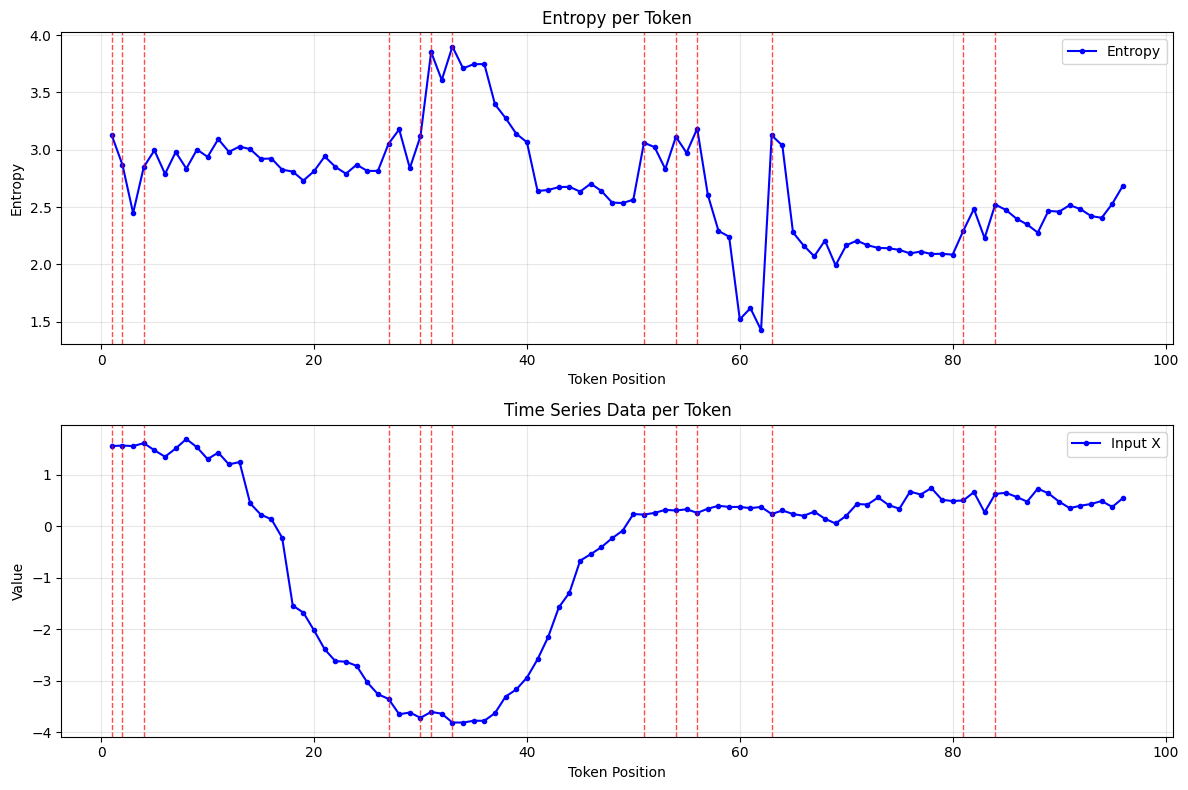

Vertical lines drawn at token positions: [ 1  2  4 27 30 31 33 51 54 56 63 81 84]


In [41]:
import matplotlib.pyplot as plt
import torch
patch_ids = find_entropy_patch_start_ids(entropies[0], patch_size=16, threshold=0.2, monotonicity=True, include_next_token=True)
# Your data processing
highlight_indices = patch_ids[idx]

highlight_indices = highlight_indices.unique()
highlight_indices = highlight_indices[highlight_indices < 96].cpu().numpy()

# Create vertical subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Entropy
y_entropy = entropies[0][idx].detach().cpu().numpy()
ax1.plot(range(1, 97), y_entropy, marker='o', color='blue', label='Entropy', markersize=3)

# Add vertical lines at highlight points
for idx in highlight_indices:
    ax1.axvline(x=idx + 1, color='red', linestyle='--', alpha=0.7, linewidth=1)

ax1.set_title("Entropy per Token")
ax1.set_xlabel("Token Position")
ax1.set_ylabel("Entropy")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Time Series
x_vals = x[idx].detach().cpu().numpy()
ax2.plot(range(1, 97), x_vals, marker='o', color='blue', label='Input X', markersize=3)

# Add vertical lines at highlight points
for idx in highlight_indices:
    ax2.axvline(x=idx + 1, color='red', linestyle='--', alpha=0.7, linewidth=1)

ax2.set_title("Time Series Data per Token")
ax2.set_xlabel("Token Position")
ax2.set_ylabel("Value")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print which positions are highlighted
print(f"Vertical lines drawn at token positions: {highlight_indices + 1}")

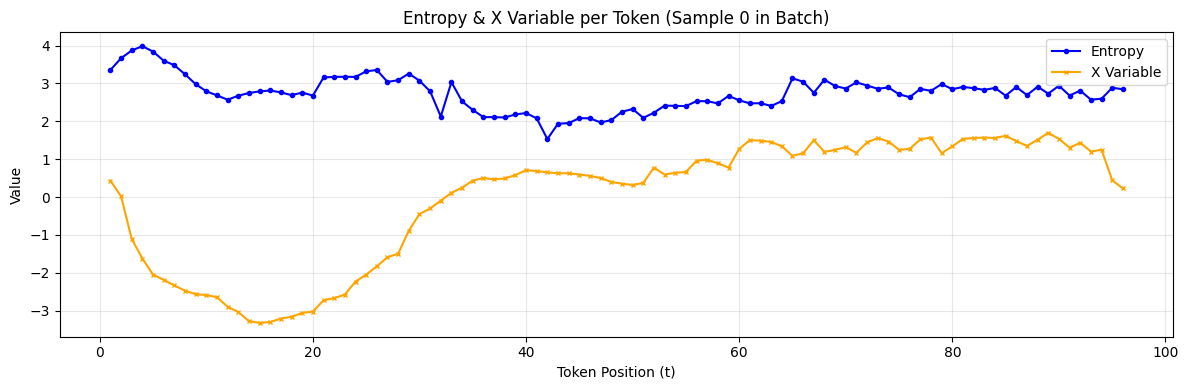

In [20]:
# plot x[0] and entropies[0][0] in same plot
import matplotlib.pyplot as plt
x_values = x[2].detach().cpu().numpy()
y_entropy = entropies[0][2].detach().cpu().numpy()
plt.figure(figsize=(12, 4))
plt.plot(range(1, 97), y_entropy, marker='o', label='Entropy', color='blue', markersize=3)
plt.plot(range(1, 97), x_values, marker='x', label='X Variable', color='orange', markersize=3)  
plt.title("Entropy & X Variable per Token (Sample 0 in Batch)")
plt.xlabel("Token Position (t)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

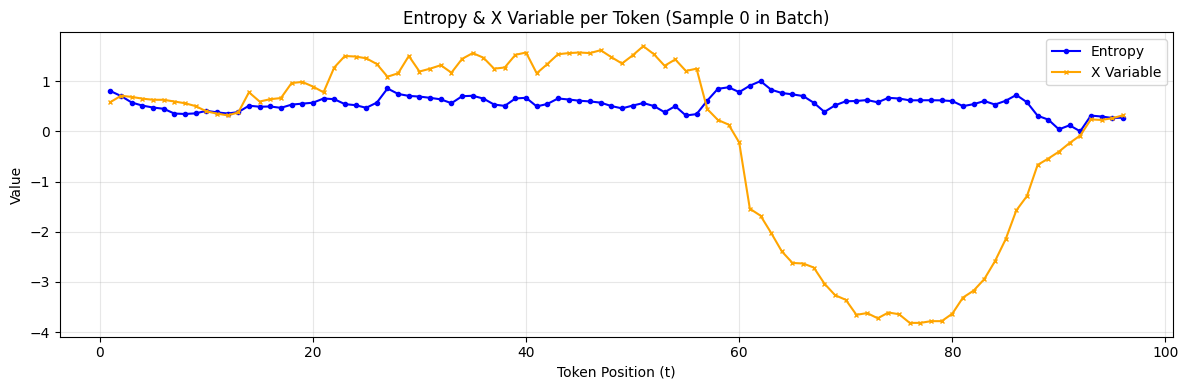

In [25]:
# plot x[0] and entropies[0][0] in same plot
import matplotlib.pyplot as plt
x_values = x[40].detach().cpu().numpy()
y_entropy = entropies[0][40].detach().cpu().numpy()
#scale y
y_entropy = (y_entropy - y_entropy.min()) / (y_entropy.max() - y_entropy.min())  # Scale to [0, 100]
plt.figure(figsize=(12, 4))
plt.plot(range(1, 97), y_entropy, marker='o', label='Entropy', color='blue', markersize=3)
plt.plot(range(1, 97), x_values, marker='x', label='X Variable', color='orange', markersize=3)  
plt.title("Entropy & X Variable per Token (Sample 0 in Batch)")
plt.xlabel("Token Position (t)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()